# Time series clustering exercise

# 1. Data Cleaning

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

In [1]:
# these commands can be run on the shell and get the data with the command wget
# the cell needs to be run only once

!for ((y=94; y<=99; y+=1)); do wget \
http://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

!for ((y=0; y<=1; y+=1)); do wget \
http://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=2; y<=9; y+=1)); do wget \
http://www2.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=10; y<=14; y+=1)); do wget \
http://www2.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done



--2017-12-11 14:12:42--  http://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp94totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:1a4::208c, 2600:141b:13:19c::208c
Connecting to www2.census.gov|104.106.248.146|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp94totals.zip?sec_ak_reference=18.6683d717.1513019562.1f33a55d [following]
--2017-12-11 14:12:42--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp94totals.zip?sec_ak_reference=18.6683d717.1513019562.1f33a55d
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611524 (597K) [application/zip]
Saving to: “zbp94totals.zip”

100%[======================================>] 611,524     --.-K/s   in 0.04s   

2017-12-11 14:12:43 (16.0 MB/s) - “zbp94totals.zip” saved [611524/611524]

--2017-12-11 14:12:43--  http://www2.census.gov/Econ2001_And_Earlie

Connecting to www2.census.gov|104.106.248.146|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://www2.census.gov/econ2012/CBP_CSV/zbp12totals.zip?sec_ak_reference=18.4d83d717.1513019568.c1aa46 [following]
--2017-12-11 14:12:48--  https://www2.census.gov/econ2012/CBP_CSV/zbp12totals.zip?sec_ak_reference=18.4d83d717.1513019568.c1aa46
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 733541 (716K) [application/zip]
Saving to: “zbp12totals.zip”

100%[======================================>] 733,541     --.-K/s   in 0.03s   

2017-12-11 14:12:48 (20.9 MB/s) - “zbp12totals.zip” saved [733541/733541]

--2017-12-11 14:12:48--  http://www2.census.gov/econ2013/CBP_CSV/zbp13totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:1a4::208c, 2600:141b:13:19c::208c
Connecting to www2.census.gov|104.106.248.146|:80... connected.
HTTP request sent, awaiting response... 302

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


## You can use zipfile module in python to unzip the files
it should be install in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands, and miss the chance to learn something new)

In [266]:
import pandas as pd
import numpy as np
import zipfile 
import geopandas as gpd
import matplotlib.pyplot as plt
import urllib
import os
from scipy.cluster.vq import kmeans2, whiten
PUIDATA = os.getenv("PUIDATA")

from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.mixture import GMM 
from sklearn.metrics import silhouette_samples, silhouette_score

In [112]:
frames = []

for i in range(94,100):
    fname='zbp' + str(i).zfill(2) + 'totals.zip'
    zf = zipfile.ZipFile(fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    df.columns = (x.lower() for x in df.columns)
    df = df[(df['zip'].astype(str).str.startswith('1'))]
    df.set_index('zip',inplace=True)
    df = df['est'].rename('19' + str(i).zfill(2))
    frames.append(df)
    
for i in range(0,15):
    fname='zbp' + str(i).zfill(2) + 'totals.zip'
    zf = zipfile.ZipFile(fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    df.columns = (x.lower() for x in df.columns)
    df = df[(df['zip'].astype(str).str.startswith('1'))]
    df.set_index('zip',inplace=True)
    df = df['est'].rename('20' + str(i).zfill(2))
    frames.append(df)

In [113]:
df = pd.concat(frames,axis=1)

In [114]:
del df.index.name

In [117]:
df.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
1000,NaN,4.0,11.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,439.0,439.0,433.0,457.0,444.0,469.0,493.0,490.0,490.0,505.0,...,509.0,509.0,503.0,477.0,458.0,448.0,436.0,453.0,439.0,458.0
1002,450.0,467.0,487.0,500.0,490.0,558.0,563.0,587.0,566.0,586.0,...,589.0,582.0,596.0,584.0,571.0,570.0,558.0,572.0,572.0,560.0
1003,10.0,10.0,13.0,15.0,14.0,13.0,13.0,13.0,15.0,16.0,...,12.0,12.0,16.0,17.0,16.0,16.0,16.0,15.0,15.0,18.0
1004,47.0,48.0,47.0,41.0,31.0,35.0,48.0,37.0,23.0,21.0,...,31.0,30.0,20.0,18.0,18.0,21.0,19.0,16.0,16.0,13.0


In [373]:
url = "https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip"

urllib.request.urlretrieve(url, "nyc.zip")

os.system("unzip -d %s nyc.zip"%(os.getenv("PUIDATA")))

nycshp = gpd.GeoDataFrame.from_file((os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp"))
nycshp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [374]:
nycshp['ZIPCODE'] = nycshp['ZIPCODE'].astype(int)
nycshp = nycshp.merge(df,left_on='ZIPCODE',right_index=True)

In [375]:
nycshp.columns

Index(['ZIPCODE', 'BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE',
       'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN',
       'geometry', '1994', '1995', '1996', '1997', '1998', '1999', '2000',
       '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014'],
      dtype='object')

In [376]:
#nycshp.drop(['zip','name','URL','BLDGZIP','STATE'], inplace = True, axis = 1)
nycshp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,...,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,...,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,...,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0


In [377]:
est = nycshp[['1994', '1995', '1996', '1997', '1998', '1999', '2000',
       '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014']].set_index(nycshp['ZIPCODE'])
est = est.dropna(0)
est.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,74.0,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0
11213,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,569.0,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0
11212,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,581.0,...,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0
11225,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,488.0,...,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0
11218,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,1247.0,...,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0


In [380]:
from sklearn import preprocessing

X_scaled = preprocessing.scale(est,axis=0)
print(X_scaled.std(axis=0))

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.]


In [381]:
X_scaled

array([[-0.64485088, -0.64378016, -0.64847982, ..., -0.71695737,
        -0.7217524 , -0.72021278],
       [-0.3335509 , -0.32699715, -0.32391302, ..., -0.19655109,
        -0.18584148, -0.1829196 ],
       [-0.24673767, -0.26364055, -0.26497852, ..., -0.20067475,
        -0.20544798, -0.19912754],
       ..., 
       [-0.26252189, -0.28162013, -0.3119553 , ..., -0.38706432,
        -0.39089276, -0.40983075],
       [-0.67466553, -0.67117761, -0.67752   , ..., -0.77798758,
        -0.78792432, -0.79152772],
       [-0.50805427, -0.50508057, -0.50840362, ..., -0.55201085,
        -0.56326655, -0.56947895]])

In [382]:
Estwhiten = whiten(est)

In [383]:
print(est.mean(axis = 0), Estwhiten.mean(axis = 0))
print(est.std(axis = 0), Estwhiten.std(axis = 0))

1994    786.374486
1995    801.930041
1996    812.234568
1997    832.506173
1998    843.716049
1999    850.288066
2000    864.934156
2001    865.695473
2002    875.000000
2003    885.600823
2004    903.263374
2005    906.395062
2006    911.337449
2007    913.864198
2008    919.263374
2009    923.489712
2010    937.012346
2011    948.156379
2012    964.320988
2013    982.485597
2014    997.716049
dtype: float64 [ 0.68957285  0.68658867  0.69374834  0.69624173  0.69930581  0.70554987
  0.70509141  0.70294723  0.73279614  0.74163092  0.7356569   0.74248158
  0.74192926  0.75299714  0.75953285  0.773116    0.78350291  0.78974433
  0.79530697  0.8026292   0.80854605]
1994    1142.732854
1995    1170.402664
1996    1173.207861
1997    1198.182206
1998    1208.995347
1999    1207.629794
2000    1229.229795
2001    1234.064543
2002    1196.521024
2003    1196.590739
2004    1230.366627
2005    1223.284020
2006    1230.869951
2007    1216.140601
2008    1212.799049
2009    1196.968869
2010    1

In [384]:
years = list(est.columns)
zips = list(est.index)

In [385]:
nycZip = est.index
type(nycZip)

pandas.indexes.numeric.Int64Index

In [386]:
X_scaled

array([[-0.64485088, -0.64378016, -0.64847982, ..., -0.71695737,
        -0.7217524 , -0.72021278],
       [-0.3335509 , -0.32699715, -0.32391302, ..., -0.19655109,
        -0.18584148, -0.1829196 ],
       [-0.24673767, -0.26364055, -0.26497852, ..., -0.20067475,
        -0.20544798, -0.19912754],
       ..., 
       [-0.26252189, -0.28162013, -0.3119553 , ..., -0.38706432,
        -0.39089276, -0.40983075],
       [-0.67466553, -0.67117761, -0.67752   , ..., -0.77798758,
        -0.78792432, -0.79152772],
       [-0.50805427, -0.50508057, -0.50840362, ..., -0.55201085,
        -0.56326655, -0.56947895]])

In [387]:
zipScale = pd.DataFrame(X_scaled)

In [388]:
zipScale.set_index(nycZip, inplace = True)
zipScale.columns = years
zipScale.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436,-0.644851,-0.643780,-0.648480,-0.653589,-0.657035,-0.657423,-0.652104,-0.656663,-0.667473,-0.679661,...,-0.675311,-0.676800,-0.683784,-0.685171,-0.696097,-0.701558,-0.705619,-0.716957,-0.721752,-0.720213
11213,-0.333551,-0.326997,-0.323913,-0.314880,-0.304778,-0.313065,-0.316243,-0.302630,-0.275531,-0.265132,...,-0.287029,-0.281957,-0.294870,-0.270398,-0.253235,-0.219087,-0.228352,-0.196551,-0.185841,-0.182920
11212,-0.246738,-0.263641,-0.264979,-0.255501,-0.269138,-0.256640,-0.281189,-0.275022,-0.249569,-0.255083,...,-0.261635,-0.277886,-0.269326,-0.262136,-0.231468,-0.199019,-0.195868,-0.200675,-0.205448,-0.199128
11225,-0.355473,-0.355251,-0.362349,-0.353350,-0.354508,-0.366171,-0.365154,-0.360282,-0.331643,-0.332964,...,-0.340275,-0.335688,-0.329476,-0.329888,-0.318534,-0.298524,-0.292487,-0.281499,-0.252830,-0.244510
11218,0.174175,0.182424,0.202227,0.202802,0.227338,0.247864,0.241352,0.255216,0.295631,0.302647,...,0.348638,0.341652,0.381610,0.394725,0.446638,0.449014,0.478802,0.528389,0.575544,0.598303


## 2. cluster the number of establishments time series with K-means

In [389]:
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(zipScale)**2)/zipScale.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

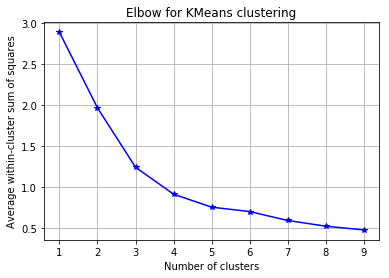

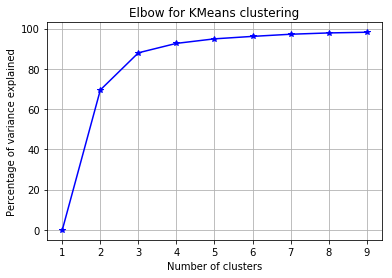

In [390]:
elbow(zipScale,range(1,10))

Figure 1. Plotting the Elbow for KMeans Clustering. The change in percent variance explained decreases considerably around the 5th cluster, so the 5 clusters will be used.

In [392]:
clusterer = KMeans (n_clusters = 5, random_state=324)
cluster_labels = clusterer.fit_predict(zipScale)
zipScale['cluster_labels'] = cluster_labels

In [393]:
cluster = zipScale[['cluster_labels']]

In [394]:
joined = pd.merge(nycshp, cluster, left_on='ZIPCODE', right_index=True)

In [395]:
joined.columns

Index(['ZIPCODE', 'BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE',
       'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN',
       'geometry', '1994', '1995', '1996', '1997', '1998', '1999', '2000',
       '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', 'cluster_labels'],
      dtype='object')

## 3. plot the cluster centers

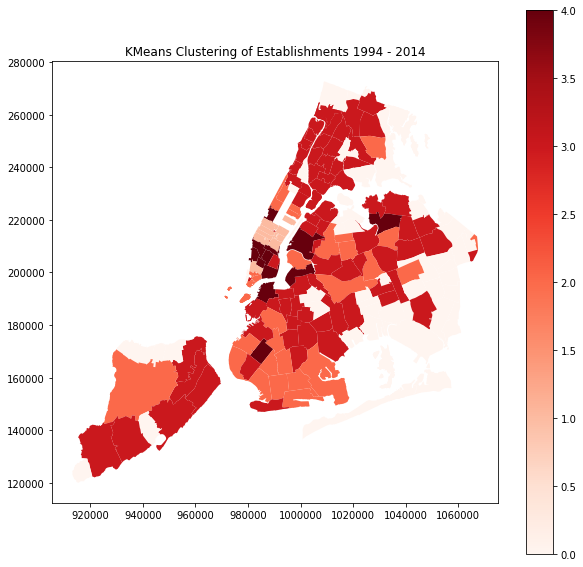

In [396]:
joined.plot(column='cluster_labels',figsize=(10,10),cmap='Reds',legend = True)
plt.title("KMeans Clustering of Establishments 1994 - 2014")
plt.show()

Figure 1. KMeans clustering on NYC business establishments by zip code, from 1994 to 2014. Large clustering can be found in the Bronx and South Brooklyn.

In [397]:
label_time = zipScale.groupby('cluster_labels').mean()
label_time.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
cluster_labels,,,,,,,,,,,,,,,,,,,,,
0,-0.530032,-0.527210,-0.533412,-0.536595,-0.539302,-0.541919,-0.542559,-0.546852,-0.569374,-0.575683,...,-0.583373,-0.583134,-0.589985,-0.595625,-0.603978,-0.613625,-0.619250,-0.624231,-0.630093,-0.634194
1,4.370148,4.383652,4.361807,4.347605,4.322545,4.299207,4.300125,4.300254,4.204901,4.173074,...,4.149171,4.149608,4.076111,4.047077,4.002741,3.952665,3.909533,3.869747,3.834398,3.797930
2,0.470355,0.467062,0.477125,0.480917,0.489728,0.501776,0.507081,0.505781,0.558499,0.570854,...,0.574304,0.575696,0.600387,0.607996,0.626071,0.642955,0.652505,0.658272,0.668947,0.680030
3,-0.145130,-0.149397,-0.146321,-0.146608,-0.146831,-0.149939,-0.152723,-0.147693,-0.133589,-0.131057,...,-0.124374,-0.125387,-0.121065,-0.117501,-0.112580,-0.105239,-0.100978,-0.094982,-0.089359,-0.087012
4,1.275052,1.275611,1.301697,1.333229,1.354284,1.383069,1.391798,1.402306,1.445493,1.477286,...,1.513414,1.513631,1.536130,1.565991,1.594814,1.627458,1.657879,1.678960,1.693795,1.713342


In [398]:
time = label_time.T
time.head()

cluster_labels,0,1,2,3,4
1994,-0.530032,4.370148,0.470355,-0.145130,1.275052
1995,-0.527210,4.383652,0.467062,-0.149397,1.275611
1996,-0.533412,4.361807,0.477125,-0.146321,1.301697
1997,-0.536595,4.347605,0.480917,-0.146608,1.333229
1998,-0.539302,4.322545,0.489728,-0.146831,1.354284


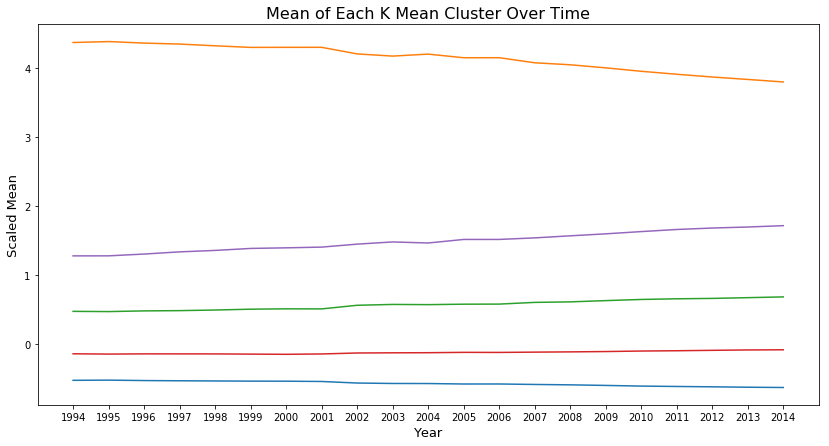

In [399]:
plt.figure(figsize=(14,7))
plt.plot(time)
plt.title("Mean of Each K Mean Cluster Over Time",fontsize=16)
plt.xlabel("Year",fontsize=13)
plt.ylabel("Scaled Mean",fontsize=13)
plt.show()

Figure 3. The Time Series for KMeans Clusters Over Time

## 4. Use another clustering algorithm

In [400]:
gm = mixture.GMM(n_components=5,random_state=324)

gmCluster_labels = gm.fit_predict(zipScale)
zipScale['gmCluster_labels'] = gmCluster_labels

cluster2 = zipScale[['gmCluster_labels']]

joined = pd.merge(nycshp, cluster2, left_on='ZIPCODE', right_index=True)

## 5. Overlay data on a NYC map

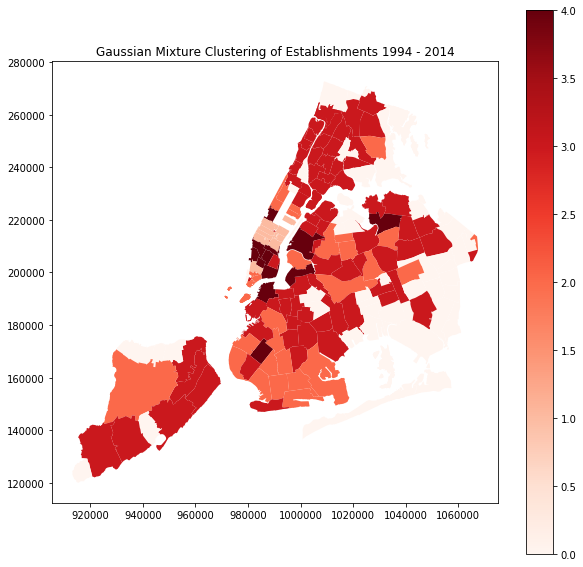

In [405]:
joined.plot(column='gmCluster_labels',figsize=(10,10),cmap='Reds',legend = True)
plt.title("Gaussian Mixture Clustering of Establishments 1994 - 2014")
plt.show()

Figure 4. Gaussian Mixture Clustering on NYC business establishments by zip code, from 1994 to 2014. Large clustering can be found in the Bronx and South Brooklyn. 

## 6. Comparing Results of the Algorithms

The results of the two algorithms are extremely similar, showing clustering in the same zip codes around New York City. 

## 7. Interpretation

Judging by the clustering maps that utilize both KMeans and Gaussian Mixture, zip codes with similar numbers of businesses establishments in New York City appear to cluster especially in South Brooklyn and the Bronx, as well as midtown Manhattan.  

Points: 10